# CEE609 Research Project: Model Train and Validate Code

Andrea Hoe and Melissa Yeung

Due 11/24/2024

# Import libraries

In [1]:
%%capture
from PIL import Image
from google.colab import drive
from scipy.interpolate import griddata
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor

drive.mount('/content/drive')

## Rebuild grid

In [2]:
GBR_loc  = np.array([[1250,2050], [7550,8250]])
GBR_sz   = np.array([GBR_loc[0,1]-GBR_loc[0,0],GBR_loc[1,1]-GBR_loc[1,0]])
xv       = np.arange(0, GBR_sz[1])
yv       = np.arange(0, GBR_sz[0])

XG, YG = np.meshgrid(xv, yv)
XGv = XG.reshape(-1, 1)
YGv = YG.reshape(-1, 1)

# Inspect training dataset

## Load in data

In [3]:
path = 'drive/MyDrive/Fall 2024/CEE609/'

WLA18 = np.load(path+"WLA18.npy")/10
PAR18 = np.load(path+"PAR18.npy")/10
PIC18 = np.load(path+"PIC18.npy")/10
POC18 = np.load(path+"POC18.npy")/10
CHL19 = np.load(path+"CHL19.npy")/10

## Look at scatterplots

In [4]:
WLA18_v = WLA18[:,0]
PAR18_v = PAR18[:,0]
PIC18_v = PIC18[:,0]
POC18_v = POC18[:,0]
CHL19_v = CHL19[:,0]

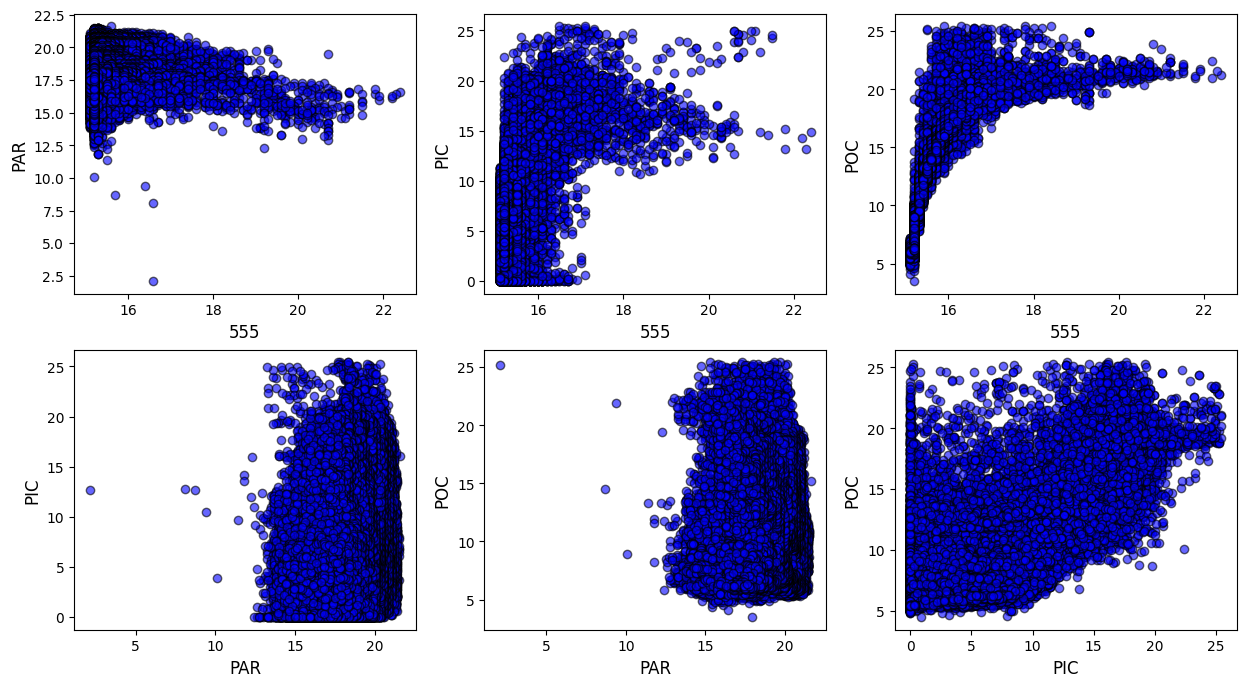

In [5]:
# between predictor variables

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

axes[0, 0].scatter(WLA18_v, PAR18_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 0].set_xlabel("555", fontsize=12);
axes[0, 0].set_ylabel("PAR", fontsize=12);

axes[0, 1].scatter(WLA18_v, PIC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 1].set_xlabel("555", fontsize=12);
axes[0, 1].set_ylabel("PIC", fontsize=12);

axes[0, 2].scatter(WLA18_v, POC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 2].set_xlabel("555", fontsize=12);
axes[0, 2].set_ylabel("POC", fontsize=12);

axes[1, 0].scatter(PAR18_v, PIC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 0].set_xlabel("PAR", fontsize=12);
axes[1, 0].set_ylabel("PIC", fontsize=12);

axes[1, 1].scatter(PAR18_v, POC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 1].set_xlabel("PAR", fontsize=12);
axes[1, 1].set_ylabel("POC", fontsize=12);

axes[1, 2].scatter(PIC18_v, POC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 2].set_xlabel("PIC", fontsize=12);
axes[1, 2].set_ylabel("POC", fontsize=12);

# fig.savefig(path+"Figures/Train_scatter_Prdrs.png", dpi=300)


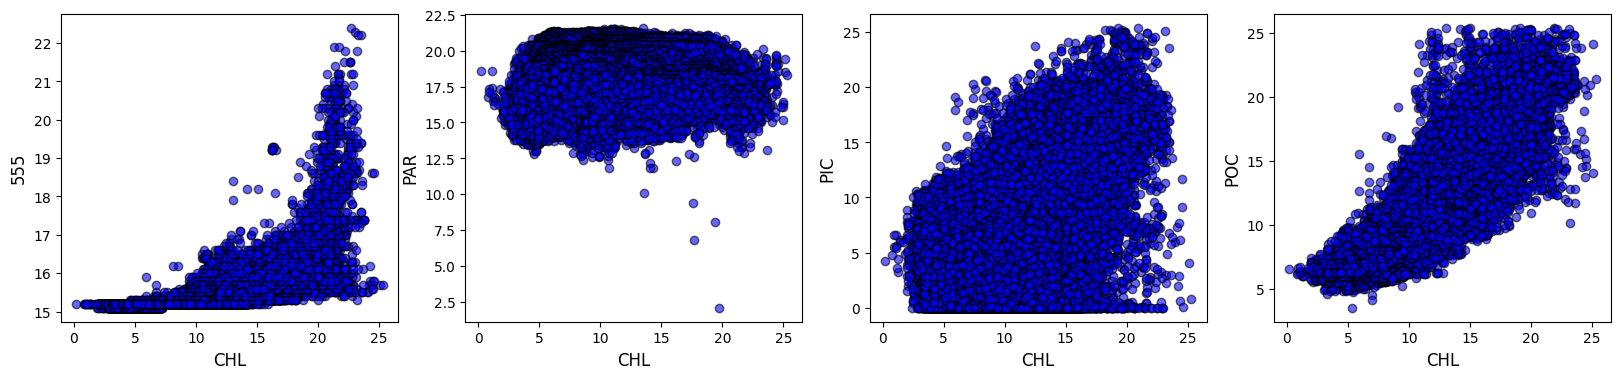

In [6]:
# between variables and predictand

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

axes[0].scatter(CHL19_v, WLA18_v, color='blue', alpha=0.6, edgecolors='k');
axes[0].set_xlabel("CHL", fontsize=12);
axes[0].set_ylabel("555", fontsize=12);

axes[1].scatter(CHL19_v, PAR18_v, color='blue', alpha=0.6, edgecolors='k');
axes[1].set_xlabel("CHL", fontsize=12);
axes[1].set_ylabel("PAR", fontsize=12);

axes[2].scatter(CHL19_v, PIC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[2].set_xlabel("CHL", fontsize=12);
axes[2].set_ylabel("PIC", fontsize=12);

axes[3].scatter(CHL19_v, POC18_v, color='blue', alpha=0.6, edgecolors='k');
axes[3].set_xlabel("CHL", fontsize=12);
axes[3].set_ylabel("POC", fontsize=12);

# fig.savefig(path+"Figures/Train_scatter_VarPdctd.png", dpi=300)


# Train the model

## Prepare the data

In [7]:
# remove rows containing NaN
data_all = np.hstack([WLA18, PAR18, PIC18, POC18, CHL19])
mask = ~np.isnan(data_all).any(axis=1)


# assign variables
X_train = np.hstack([WLA18, PAR18, PIC18, POC18])
Y_train = CHL19

X_train = X_train[mask]
Y_train = Y_train[mask]


# ensure there are no NaN values
print("NaN values in X_train: ", np.isnan(X_train).any())
print("NaN values in Y_train: ", np.isnan(Y_train).any())

# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


print("\nShape of X_train: ", X_train.shape)
print("Shape of Y_train: ", Y_train.shape)


NaN values in X_train:  False
NaN values in Y_train:  False

Shape of X_train:  (186336, 144)
Shape of Y_train:  (186336, 1)


## Train
* Search for best parameter

In [8]:
parameters  = {'alpha': [1270, 1280, 1290, 1300, 1310, 1320, 1330]} # has been tested multiple times and narrowed down
ridge       = Ridge()
grid_search = GridSearchCV(ridge, parameters, cv=5)
grid_search.fit(X_train, Y_train)


best_alpha = grid_search.best_params_['alpha']
print("Best alpha:", best_alpha)


model        = grid_search.best_estimator_
Y_train_pred = model.predict(X_train)
Y_test_pred  = model.predict(X_test)


coefficients = model.coef_
print("Model Coefficients:", coefficients)

Best alpha: 1270
Model Coefficients: [[ 9.06715263e-04 -1.07425489e-01 -3.29254526e-01 -1.86992745e-01
  -8.75126103e-02  4.49914387e-02 -2.27867419e-01 -1.64225855e-02
  -1.12783781e-01 -1.86956926e-01  2.21196059e-01  6.63258817e-02
   9.38920505e-02  1.59236814e-01  1.73245108e-01  1.17014774e-02
  -1.03492472e-02 -4.11110767e-02 -1.87353668e-01 -3.43005432e-02
   4.33843064e-02  5.13028146e-02 -5.82997041e-02  2.09425663e-01
   4.60751086e-02 -1.46477159e-01 -1.22090444e-01 -3.51815835e-01
  -1.96229482e-01  7.38407558e-02 -1.29054566e-01 -4.68543948e-02
   9.66031500e-02  1.54827578e-01  4.11122693e-02  8.20620161e-02
  -1.30525088e-02  3.40663213e-02 -4.18033710e-02  1.08312291e-03
  -6.86739464e-02  2.00950540e-02  1.06701863e-01 -4.02611305e-02
   6.35299926e-02  2.06287736e-02  6.57085482e-02 -1.48678216e-02
   1.30333229e-02  6.46630195e-02 -4.47844288e-02  5.12706857e-02
  -1.03520255e-02  1.48134411e-02 -6.60284250e-02 -3.76004231e-04
  -4.67042793e-02 -1.93834596e-02 -4.72

## Save the model

In [35]:
import joblib

joblib.dump(model, path+"Model_Outputs/model.pkl")

['drive/MyDrive/Fall 2024/CEE609/Model_Outputs/model.pkl']

## Model Evaluation


In [9]:
print("Training Set Performance:")
print("> MSE:", mean_squared_error(Y_train, Y_train_pred))
print("> R^2 Score:", r2_score(Y_train, Y_train_pred))

err_train = abs( (Y_train_pred - Y_train) / Y_train )
print("> Mean Error: " + str(np.mean(err_train)*100) + "%")



print("\nTest Set Performance:")
print("> MSE:", mean_squared_error(Y_test, Y_test_pred))
print("> R^2 Score:", r2_score(Y_test, Y_test_pred))

err_test = abs( (Y_test_pred - Y_test) / Y_test )
print("> Mean Error: " + str(np.mean(err_test)*100) + "%")


Training Set Performance:
> MSE: 0.5205671646383059
> R^2 Score: 0.9260260071656283
> Mean Error: 6.5845003212486315%

Test Set Performance:
> MSE: 0.5357543912359567
> R^2 Score: 0.9246775430163605
> Mean Error: 6.668159403421904%


## Compare through plots

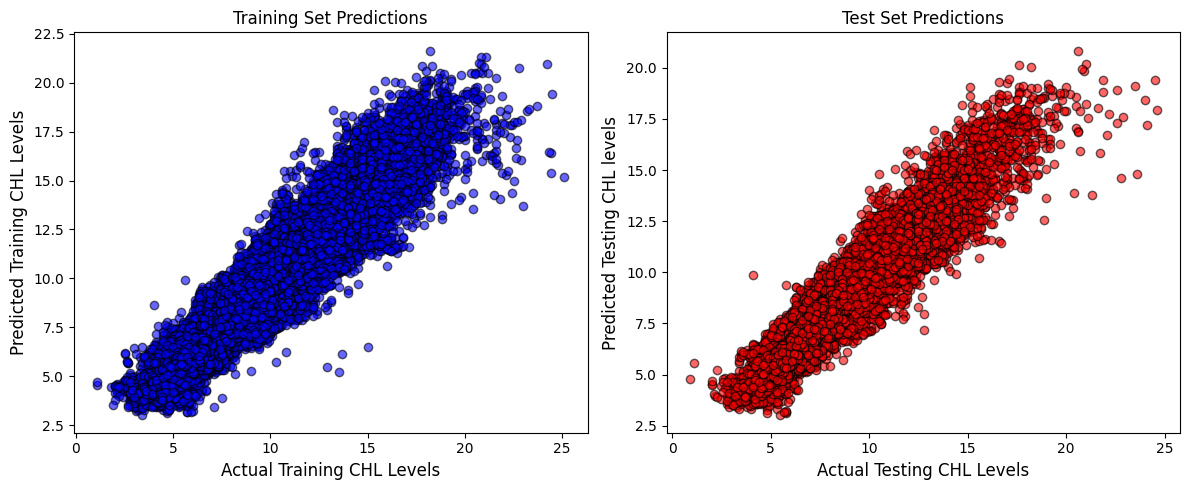

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].scatter(Y_train, Y_train_pred, color='blue', alpha=0.6, edgecolors='k')
axes[0].set_xlabel("Actual Training CHL Levels", fontsize=12)
axes[0].set_ylabel("Predicted Training CHL Levels", fontsize=12)
axes[0].set_title("Training Set Predictions")

axes[1].scatter(Y_test, Y_test_pred, color='red', alpha=0.6, edgecolors='k')
axes[1].set_xlabel("Actual Testing CHL Levels", fontsize=12)
axes[1].set_ylabel("Predicted Testing CHL levels", fontsize=12)
axes[1].set_title("Test Set Predictions")


plt.tight_layout()
plt.show()


# fig.savefig(path+"Figures/Train_ModelEval.png", dpi=300)


## Test using full training dataset

In [11]:
# remove rows containing NaN
X_test = np.hstack([WLA18, PAR18, PIC18, POC18])
mask = ~np.isnan(X_test).any(axis=1)

X_test = X_test[mask]
xgv    = XGv[mask]
ygv    = YGv[mask]

# ensure there are no NaN values
print("NaN values in X_test: ", np.isnan(X_test).any())


print("Shape of X_test: ", X_test.shape)
print("Shape of xgv   : ", xgv.shape)
print("Shape of ygv.  : ", ygv.shape)

NaN values in X_test:  False
Shape of X_test:  (234824, 144)
Shape of xgv   :  (234824, 1)
Shape of ygv.  :  (234824, 1)


In [12]:
Y_test = model.predict(X_test)

### Reinterpolate onto grid and plot

In [13]:
# interpolate onto grid
Y_interp = griddata((xgv.flatten(), ygv.flatten()), Y_test.flatten(), (XG, YG), method='linear')

# mask out continent
MASK = mask.reshape(GBR_sz[0], GBR_sz[1])
Y_interp[~MASK] = np.nan


# actual image
Y_true = CHL19[:,0]
Y_true = np.reshape(Y_true, (GBR_sz[0], GBR_sz[1]))

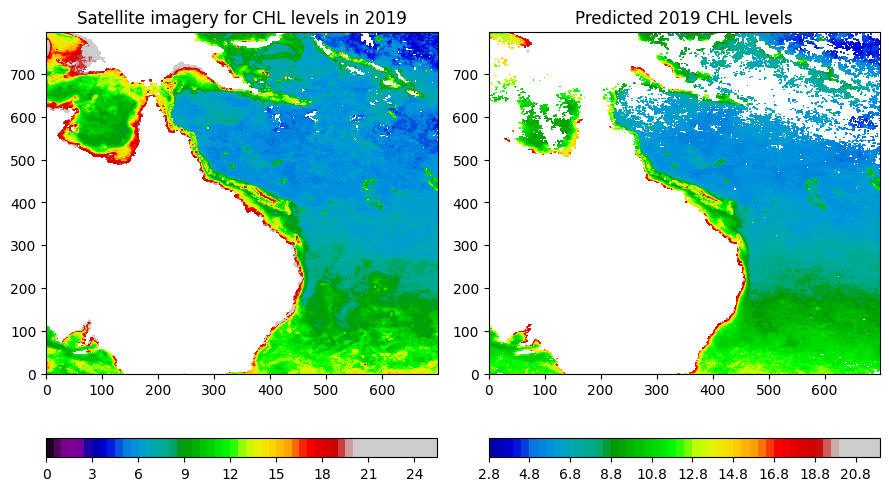

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))


im1 = axes[0].contourf(XG, YG, Y_true, levels=50, cmap="nipy_spectral", vmin=0, vmax=20)
fig.colorbar(im1, ax=axes[0], orientation='horizontal', fraction=0.05)
axes[0].set_title('Satellite imagery for CHL levels in 2019')


im2 = axes[1].contourf(XG, YG, Y_interp, levels=50, cmap="nipy_spectral", vmin=0, vmax=20)
fig.colorbar(im2, ax=axes[1], orientation='horizontal', fraction=0.05)
axes[1].set_title('Predicted 2019 CHL levels')


plt.tight_layout()
plt.show()


# fig.savefig(path+"Figures/2019_prediction.png", dpi=300)


# Feed in data from 2021 - 2024

## Load in data

In [25]:
path = 'drive/MyDrive/Fall 2024/CEE609/'

WLA24 = np.load(path+"WLA24.npy")/10
PAR24 = np.load(path+"PAR24.npy")/10
PIC24 = np.load(path+"PIC24.npy")/10
POC24 = np.load(path+"POC24.npy")/10

## Look at scatterplots

In [26]:
WLA24_v = WLA24[:,0]
PAR24_v = PAR24[:,0]
PIC24_v = PIC24[:,0]
POC24_v = POC24[:,0]

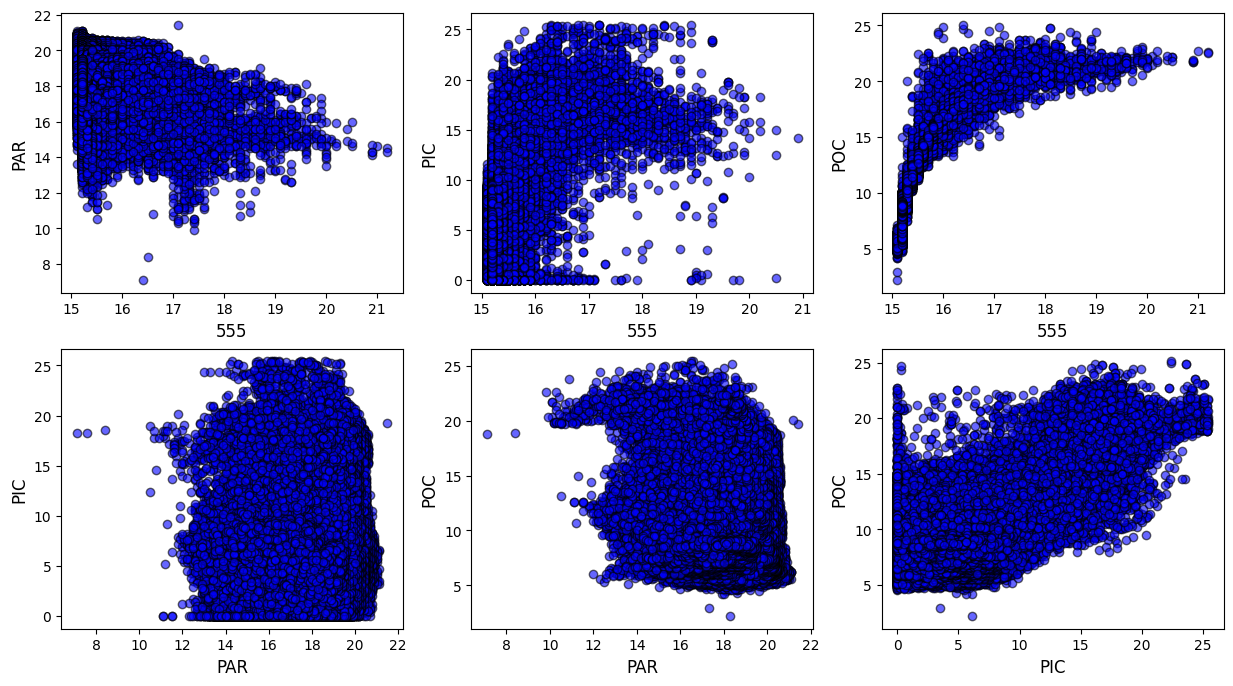

In [27]:
# between predictor variables

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

axes[0, 0].scatter(WLA24_v, PAR24_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 0].set_xlabel("555", fontsize=12);
axes[0, 0].set_ylabel("PAR", fontsize=12);

axes[0, 1].scatter(WLA24_v, PIC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 1].set_xlabel("555", fontsize=12);
axes[0, 1].set_ylabel("PIC", fontsize=12);

axes[0, 2].scatter(WLA24_v, POC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[0, 2].set_xlabel("555", fontsize=12);
axes[0, 2].set_ylabel("POC", fontsize=12);

axes[1, 0].scatter(PAR24_v, PIC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 0].set_xlabel("PAR", fontsize=12);
axes[1, 0].set_ylabel("PIC", fontsize=12);

axes[1, 1].scatter(PAR24_v, POC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 1].set_xlabel("PAR", fontsize=12);
axes[1, 1].set_ylabel("POC", fontsize=12);

axes[1, 2].scatter(PIC24_v, POC24_v, color='blue', alpha=0.6, edgecolors='k');
axes[1, 2].set_xlabel("PIC", fontsize=12);
axes[1, 2].set_ylabel("POC", fontsize=12);

# fig.savefig(path+"Figures/2024_scatter_Prdrs.png", dpi=300)


## Prepare data

In [28]:
# remove rows containing NaN
X = np.hstack([WLA24, PAR24, PIC24, POC24])
mask = ~np.isnan(X).any(axis=1)

X   = X[mask]
xgv = XGv[mask]
ygv = YGv[mask]

# ensure there are no NaN values
print("NaN values in X: ", np.isnan(X).any())


print("Shape of X  : ", X.shape)
print("Shape of xgv: ", xgv.shape)
print("Shape of ygv: ", ygv.shape)

NaN values in X:  False
Shape of X  :  (197578, 144)
Shape of xgv:  (197578, 1)
Shape of ygv:  (197578, 1)


## Model prediction

In [29]:
Y = model.predict(X)

## Reinterpolate onto grid and plot

In [30]:
# interpolate onto grid
Y_interp = griddata((xgv.flatten(), ygv.flatten()), Y.flatten(), (XG, YG), method='linear')

# mask out continent
MASK = mask.reshape(GBR_sz[0], GBR_sz[1])
Y_interp[~MASK] = np.nan


## Load in most current sattelite image

In [31]:
url = "https://oceancolor.gsfc.nasa.gov/showimages/MODISA/IMAGES/CHL/L3/2024/1001/AQUA_MODIS.20241001_20241031.L3m.MO.CHL.chlor_a.4km.NRT.nc.png"

image = Image.open(urllib.request.urlopen(url))
image_array = np.array(image)

image_nan = np.where(image_array == 255, np.nan , image_array)
image_masked = np.ma.masked_invalid(image_nan)
image_masked = np.flipud(image_masked)

CHL24  = image_masked[GBR_loc[0,0]:GBR_loc[0,1], GBR_loc[1,0]:GBR_loc[1,1]] / 10

## Plot most recent CHL levels and compare with 2025 prediction

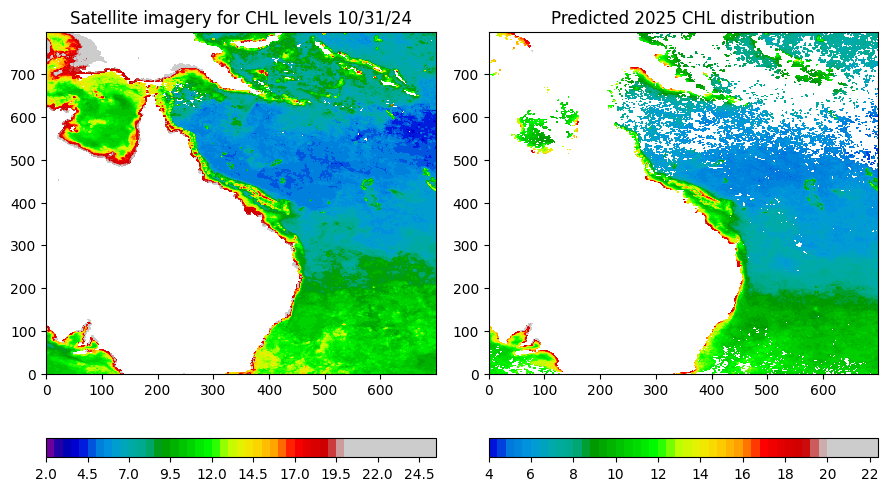

In [34]:
# from matplotlib.colors import LogNorm

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))


im1 = axes[0].contourf(XG, YG, CHL24, levels=50, cmap="nipy_spectral", vmin=0, vmax=20)
fig.colorbar(im1, ax=axes[0], orientation='horizontal', fraction=0.05)
axes[0].set_title('Satellite imagery for CHL levels 10/31/24')


im2 = axes[1].contourf(XG, YG, Y_interp, levels=50, cmap="nipy_spectral", vmin=0, vmax=20)
fig.colorbar(im2, ax=axes[1], orientation='horizontal', fraction=0.05)
axes[1].set_title('Predicted 2025 CHL distribution')


plt.tight_layout()
plt.show()

# fig.savefig(path+"Figures/2025_prediction.png", dpi=300)
